# Simulación 1.0 de cadenas rígidas usando un snapshot.

### Objetivo: crear cadenas rígidas y poblar la caja de simulación usando un snapshot.

#### Como de costumbre primero importamos los paquetes que vamos a utilizar para poder correr la simulación.

In [18]:
import hoomd
import hoomd.md
import ex_render

#### Definimos los parámetros de la simulación, como se pueden dar cuenta, esta comentada la densidad, esto es así porque aún no se me ocurre bien cómo tener un control de ella.Tengo algunas ideas, pero si se les ocurre algo más sería de mucha ayuda. La caja en la que se colocan las partículas es muy larga, algo así como una torre de jenga.

In [19]:
#--- Initialization
# Define parameters for this simulation
gb_kappa = 5.0;
gb_parallel_semiaxis = gb_kappa/2.0;
gb_perpendicular_semiaxis = 0.50;
gb_epsilon =1.0;
gb_r_cut = 6.5;

#density= 0.005;
temperature= 0.70; 
md_time_step = 0.001

#print("rho= ", density)
print("T= ", temperature);
print("dt= ", md_time_step);

unit_cell_side_3 = 1.0/(gb_kappa*density)**(1./3.);
unit_cell_side_2 = unit_cell_side_3
unit_cell_side_1 = gb_kappa*unit_cell_side_3;

n_x = 4;
n_y = 15;
n_z = n_y;

print("cell sides= ", unit_cell_side_1, unit_cell_side_2, unit_cell_side_3);
print("repeats= "   , n_x, n_y, n_z);

T=  0.7
dt=  0.001
cell sides=  17.09975946676697 3.4199518933533937 3.4199518933533937
repeats=  4 15 15


#### En las siguientes dos lineas de código se define el contexto de simulación (en dónde se realizara la simulación) y se crea una caja, por el momento sólo puse 6 partículas que son las que forman la cadena, y puse una cadena por caja, como se pueden dar cuenta es algo que todavia tengo que mejorar.

In [20]:
# Define a simulation context
sim1 = hoomd.context.initialize("");

In [20]:
# Create the snapshot
snapshot = hoomd.data.make_snapshot(N=6,
                                    box=hoomd.data.boxdim(Lx = unit_cell_side_1, 
                                                          Ly = unit_cell_side_2, 
                                                          Lz = unit_cell_side_3),
                                    particle_types=['A', 'B'],
                                    bond_types=['rigid']);

#### En la siguiente linea de código es donde le digo a la maquina que quiero que las particulas estén pegadas formando una cadena y de igual manera replico la caja que acabo de hacer en la linea de arriba en las direcciones "x", "y"  y "z".

In [20]:
#Assign the positions of the chain
snapshot.particles.position[:] = [[-2.5, 0, 0], [-1.5, 0, 0],
                                  [-0.5, 0, 0], [0.5, 0, 0],
                                  [1.5, 0, 0], [2.5, 0, 0]];
# Assign the types to make a chain
snapshot.particles.typeid[0:3]=0;
snapshot.particles.typeid[3:6]=1;
# Create the bonds between neighbors in the chain
snapshot.bonds.resize(5);
snapshot.bonds.group[:] = [[0,1], [1, 2], [2,3],
                           [3,4], [4,5]];
# Replicate the snapshot to create many chains.
snapshot.replicate(n_x,n_y,n_z);

In [20]:
# Initialize the system with this snapshot as the system configuration.
hoomd.init.read_snapshot(snapshot);
# Define the forces
nl = hoomd.md.nlist.cell();
lj = hoomd.md.pair.lj(r_cut=3.0, nlist=nl);
lj.pair_coeff.set(['A','B'],['A','B'], epsilon=1.0, sigma=1.0);
# Select integrator
hoomd.md.integrate.mode_standard(dt=md_time_step);
all = hoomd.group.all();
hoomd.md.integrate.langevin(group=all, kT=0.2, seed=42);

In [20]:
# Write output
hoomd.analyze.log(filename="log-output.log",
                  quantities=['potential_energy', 'temperature'],
                  period=100,
                  overwrite=True);
hoomd.dump.gsd("trajectory.gsd", period=2e3, group=all, overwrite=True);

In [20]:
# Run the simulation
hoomd.run(1e4);

notice(2): Group "all" created containing 5400 particles
notice(2): integrate.langevin/bd is using specified gamma values
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 1 exclusions             : 1800
notice(2): Particles with 2 exclusions             : 3600
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 6792 / 10000 | TPS 679.116 | ETA 00:00:04
Time 00:00:15 | Step 10000 / 10000 | TPS 589.222 | ETA 00:00:00
Average TPS: 647.382
---------
-- Neighborlist stats:
89 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 29 / n_neigh_avg: 6.46463
shortest rebuild period: 62
-- Cell list stats:
Dimension: 20, 15, 15
n_min    : 0 / n_max: 24 / n_avg: 1.2
** run complete **


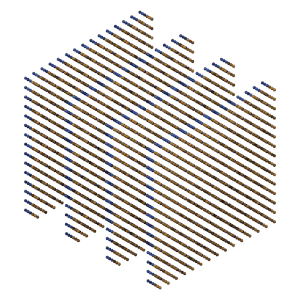

In [21]:
import ex_render
ex_render.display_movie(ex_render.render_sphere_frame, 'trajectory.gsd');